<a href="https://colab.research.google.com/github/seung-bin99/project/blob/main/%EA%B5%90%ED%86%B5%EC%82%AC%EA%B3%A0%EC%98%88%EC%B8%A1_%ED%86%A0%EC%B9%98%EB%B2%84%EC%A0%84_%EB%B2%A0%EC%8A%A4%ED%8A%B8%EA%B2%B0%EA%B3%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(99) # Seed 고정

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
import optuna


In [ ]:
light_df = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])

light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)

child_area_df = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()[['소재지지번주소']]
# 어린이 보호구역을 의미
child_area_df['보호구역'] = 1

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])

child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)

parking_df = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/external_open/대구 주차장 정보.csv', encoding='cp949')[['소재지지번주소', '급지구분']]
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])

parking_df = parking_df.groupby(['도시', '구', '동']).sum().reset_index()
parking_df.reset_index(inplace=True, drop=True)


In [ ]:
train_org = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/train.csv')
test_org = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/sample_submission.csv')


In [ ]:
train_df = train_org.copy()
test_df = test_org.copy()

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

In [ ]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

In [ ]:
# train_df와 test_df에, light_df와 child_area_df, parking_df를 merge하세요.
train_df = pd.merge(train_df, light_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, child_area_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, parking_df, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, light_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, child_area_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, parking_df, how='left', on=['도시', '구', '동'])


In [ ]:
test_x = test_df.drop(columns=['ID']).copy()
train_x = train_df[test_x.columns].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
train_x.isna().sum()

사고일시          0
요일            0
기상상태          0
노면상태          0
사고유형          0
도시            0
구             0
동             0
도로형태1         0
도로형태2         0
설치개수       9513
보호구역      18426
급지구분_1     6543
급지구분_2     6543
급지구분_3     6543
dtype: int64

In [ ]:
test_x.isna().sum()

사고일시         0
요일           0
기상상태         0
노면상태         0
사고유형         0
도시           0
구            0
동            0
도로형태1        0
도로형태2        0
설치개수      2771
보호구역      4961
급지구분_1    1928
급지구분_2    1928
급지구분_3    1928
dtype: int64

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# IterativeImputer 모델 생성
imputer = IterativeImputer(max_iter=10, random_state=0)

# '설치개수', '보호구역', '급지구분_1', '급지구분_2', '급지구분_3' 열을 포함한 열들 선택
selected_columns = ['설치개수', '보호구역', '급지구분_1', '급지구분_2', '급지구분_3']
data_for_imputation = train_x[selected_columns]

# IterativeImputer를 사용하여 결측치 채우기
imputed_data = imputer.fit_transform(data_for_imputation)

# 결과를 기존 데이터프레임에 적용
train_x[selected_columns] = imputed_data

# train 데이터프레임에 결측치가 없는지 확인
train_x.isna().sum()


사고일시      0
요일        0
기상상태      0
노면상태      0
사고유형      0
도시        0
구         0
동         0
도로형태1     0
도로형태2     0
설치개수      0
보호구역      0
급지구분_1    0
급지구분_2    0
급지구분_3    0
dtype: int64

In [ ]:
# '설치개수', '보호구역', '급지구분_1', '급지구분_2', '급지구분_3' 열을 포함한 열들 선택
selected_columns = ['설치개수', '보호구역', '급지구분_1', '급지구분_2', '급지구분_3']
data_for_imputation = test_x[selected_columns]

# IterativeImputer를 사용하여 결측치 채우기
imputed_data = imputer.transform(data_for_imputation)

# 결과를 기존 데이터프레임에 적용
test_x[selected_columns] = imputed_data

# test 데이터프레임에 결측치가 없는지 확인
test_x.isna().sum()

사고일시      0
요일        0
기상상태      0
노면상태      0
사고유형      0
도시        0
구         0
동         0
도로형태1     0
도로형태2     0
설치개수      0
보호구역      0
급지구분_1    0
급지구분_2    0
급지구분_3    0
dtype: int64

In [ ]:
# '사고일시' 열을 datetime 형식으로 변환
train_x['사고일시'] = pd.to_datetime(train_x['사고일시'])

# datetime에서 year, month, day, hour 추출하여 새로운 열 생성
train_x['year'] = train_x['사고일시'].dt.year
train_x['month'] = train_x['사고일시'].dt.month
train_x['day'] = train_x['사고일시'].dt.day
train_x['hour'] = train_x['사고일시'].dt.hour

# '사고일시' 열 삭제
train_x.drop(columns=['사고일시'], inplace=True)

In [ ]:
# '사고일시' 열을 datetime 형식으로 변환
test_x['사고일시'] = pd.to_datetime(test_x['사고일시'])

# datetime에서 year, month, day, hour 추출하여 새로운 열 생성
test_x['year'] = test_x['사고일시'].dt.year
test_x['month'] = test_x['사고일시'].dt.month
test_x['day'] = test_x['사고일시'].dt.day
test_x['hour'] = test_x['사고일시'].dt.hour

# '사고일시' 열 삭제
test_x.drop(columns=['사고일시'], inplace=True)


In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = TargetEncoder(cols=[i])
    train_x[i] = le.fit_transform(train_x[i], train_y)
    test_x[i] = le.transform(test_x[i])

display(train_x.head())
display(test_x.head())

['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2']

,요일,기상상태,노면상태,사고유형,도시,구,동,도로형태1,도로형태2,설치개수,보호구역,급지구분_1,급지구분_2,급지구분_3,year,month,day,hour
0,4.627926,4.712888,4.712878,3.817650,4.726704,4.541610,4.282449,4.671841,4.599599,391.0,2.000000,11.00000,0.000000,0.000000,2019,1,1,0
1,4.627926,4.779150,4.712878,3.817650,4.726704,4.618441,4.738938,4.671841,4.599599,932.0,14.400447,0.00000,1.000000,3.000000,2019,1,1,0
2,4.627926,4.712888,4.712878,3.817650,4.726704,4.727300,4.842715,4.671841,4.599599,473.0,5.000000,3.71896,4.753207,2.504704,2019,1,1,1
3,4.627926,4.712888,4.712878,4.944597,4.726704,4.687669,4.208920,4.671841,4.599599,534.0,11.000000,0.00000,9.000000,5.000000,2019,1,1,2
4,4.627926,4.712888,4.712878,4.944597,4.726704,4.889534,4.549091,4.671841,4.599599,2057.0,22.187096,0.00000,1.000000,0.000000,2019,1,1,4


,요일,기상상태,노면상태,사고유형,도시,구,동,도로형태1,도로형태2,설치개수,보호구역,급지구분_1,급지구분_2,급지구분_3,year,month,day,hour
0,4.920811,4.712888,4.712878,3.817650,4.726704,4.727300,4.881657,4.882281,5.006142,700.000000,5.000000,4.875551,5.000303,2.443914,2022,1,1,1
1,4.920811,4.712888,4.712878,3.817650,4.726704,4.727300,4.563008,4.671841,4.599599,278.938689,10.000000,0.000000,0.000000,2.000000,2022,1,1,1
2,4.920811,4.712888,4.712878,4.944597,4.726704,4.727300,4.945578,4.882281,5.006142,-493.931515,1.000000,0.829591,4.132296,2.324478,2022,1,1,4
3,4.920811,4.712888,4.712878,4.944597,4.726704,4.727300,4.438172,4.671841,4.599599,-37.623509,7.000000,0.000000,2.000000,1.000000,2022,1,1,4
4,4.920811,4.712888,4.712878,4.944597,4.726704,4.618441,4.738938,4.882281,5.006142,932.000000,14.400447,0.000000,1.000000,3.000000,2022,1,1,6


In [ ]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super(RMSLELoss, self).__init__()

    def forward(self, predictions, targets):
        assert len(predictions) == len(targets), "Predictions and targets must have the same length."

        predictions = torch.clamp(predictions, 0.0)  # 예측값이 음수이면 0으로 조정
        log_diff = torch.log(predictions + 1) - torch.log(targets + 1)
        return torch.sqrt(torch.mean(log_diff**2))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

# Convert training data to PyTorch Tensor
train_tensor_x = torch.tensor(train_x.values, dtype=torch.float32)
train_tensor_y = torch.tensor(train_y.values, dtype=torch.float32)

# Define the number of folds
num_folds = 5

# Initialize KFold
kf = KFold(n_splits=num_folds, shuffle=True)

# Lists to store results
all_train_dataloaders = []
all_val_dataloaders = []

# Create k-fold splits and dataloaders
for train_index, val_index in kf.split(train_tensor_x):
    train_x_fold, val_x_fold = train_tensor_x[train_index], train_tensor_x[val_index]
    train_y_fold, val_y_fold = train_tensor_y[train_index], train_tensor_y[val_index]

    # Create datasets
    train_dataset_fold = TensorDataset(train_x_fold, train_y_fold)
    val_dataset_fold = TensorDataset(val_x_fold, val_y_fold)

    batch_size = 64
    # Create dataloaders
    train_dataloader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)
    val_dataloader_fold = DataLoader(val_dataset_fold, batch_size=batch_size, shuffle=False)

    # Append to lists
    all_train_dataloaders.append(train_dataloader_fold)
    all_val_dataloaders.append(val_dataloader_fold)


In [ ]:
# 신경망 모델 정의
class TrafficAccidentPredictorImproved(nn.Module):
    def __init__(self, input_size):
        super(TrafficAccidentPredictorImproved, self).__init__()
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.fc1 = nn.Linear(input_size, 256)
        self.dropout1 = nn.Dropout(0.4)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)  # 드롭아웃 비율 설정
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
    def forward(self, x):
        x = self.batch_norm(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

In [ ]:
import optuna

def objective(trial):
    # 하이퍼파라미터 탐색 범위 지정
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    patience = trial.suggest_int('patience', 5, 50)

    # 모델 초기화
    input_size = len(train_x.columns)
    model = TrafficAccidentPredictorImproved(input_size)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 손실 함수 및 최적화 알고리즘 정의
    criterion = RMSLELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 훈련 중에 손실을 기록할 리스트
    train_losses = []
    val_losses = []

    # 모델 훈련
    epochs = 100

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(train_dataloader_fold):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # 훈련 손실 기록
        train_losses.append(total_train_loss / len(train_dataloader_fold))

        # 검증 손실 기록
        model.eval()
        with torch.no_grad():
            total_val_loss = 0.0
            for val_batch_idx, (val_inputs, val_labels) in enumerate(val_dataloader_fold):
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels.view(-1, 1))
                total_val_loss += val_loss.item()

            val_losses.append(total_val_loss / len(val_dataloader_fold))

        # 에폭마다 손실 출력
        print(f'Epoch {epoch + 1}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

        # 조기 종료 체크
        if epoch > patience and min(val_losses[-patience:]) >= min(val_losses):
            print("Early stopping!")
            break

    # 최적화하려는 목적 함수 (여기서는 검증 손실의 최솟값을 찾음)
    return min(val_losses)

# Optuna 스터디 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2023-12-03 16:52:13,647] A new study created in memory with name: no-name-bbc955ee-bf49-4e76-98e7-d2738e707eb1


Epoch 1, Training Loss: 1.0160, Validation Loss: 0.4834
Epoch 2, Training Loss: 0.4878, Validation Loss: 0.4590
Epoch 3, Training Loss: 0.4776, Validation Loss: 0.4535
Epoch 4, Training Loss: 0.4730, Validation Loss: 0.4519
Epoch 5, Training Loss: 0.4728, Validation Loss: 0.4508
Epoch 6, Training Loss: 0.4695, Validation Loss: 0.4490
Epoch 7, Training Loss: 0.4696, Validation Loss: 0.4476
Epoch 8, Training Loss: 0.4683, Validation Loss: 0.4469
Epoch 9, Training Loss: 0.4684, Validation Loss: 0.4457
Epoch 10, Training Loss: 0.4651, Validation Loss: 0.4459
Epoch 11, Training Loss: 0.4660, Validation Loss: 0.4443
Epoch 12, Training Loss: 0.4656, Validation Loss: 0.4440
Epoch 13, Training Loss: 0.4641, Validation Loss: 0.4433
Epoch 14, Training Loss: 0.4623, Validation Loss: 0.4425
Epoch 15, Training Loss: 0.4633, Validation Loss: 0.4425
Epoch 16, Training Loss: 0.4614, Validation Loss: 0.4414
Epoch 17, Training Loss: 0.4627, Validation Loss: 0.4416
Epoch 18, Training Loss: 0.4606, Validat

[I 2023-12-03 16:53:08,532] Trial 0 finished with value: 0.43820524023425195 and parameters: {'lr': 3.099041631255458e-05, 'patience': 28}. Best is trial 0 with value: 0.43820524023425195.


Epoch 30, Training Loss: 0.4569, Validation Loss: 0.4382
Early stopping!
Epoch 1, Training Loss: 0.8611, Validation Loss: 0.4733
Epoch 2, Training Loss: 0.4806, Validation Loss: 0.4539
Epoch 3, Training Loss: 0.4735, Validation Loss: 0.4524
Epoch 4, Training Loss: 0.4694, Validation Loss: 0.4492
Epoch 5, Training Loss: 0.4675, Validation Loss: 0.4471
Epoch 6, Training Loss: 0.4692, Validation Loss: 0.4462


[I 2023-12-03 16:53:21,083] Trial 1 finished with value: 0.4445791595405148 and parameters: {'lr': 3.969393784850211e-05, 'patience': 5}. Best is trial 0 with value: 0.43820524023425195.


Epoch 7, Training Loss: 0.4654, Validation Loss: 0.4446
Early stopping!
Epoch 1, Training Loss: 1.6347, Validation Loss: 1.3519
Epoch 2, Training Loss: 1.0048, Validation Loss: 0.6982
Epoch 3, Training Loss: 0.5836, Validation Loss: 0.4941
Epoch 4, Training Loss: 0.5036, Validation Loss: 0.4763
Epoch 5, Training Loss: 0.4931, Validation Loss: 0.4678
Epoch 6, Training Loss: 0.4879, Validation Loss: 0.4639
Epoch 7, Training Loss: 0.4839, Validation Loss: 0.4625


[I 2023-12-03 16:53:35,050] Trial 2 finished with value: 0.4560140296816826 and parameters: {'lr': 1.0214657565608344e-05, 'patience': 6}. Best is trial 0 with value: 0.43820524023425195.


Epoch 8, Training Loss: 0.4812, Validation Loss: 0.4560
Early stopping!
Epoch 1, Training Loss: 1.3569, Validation Loss: 1.0210
Epoch 2, Training Loss: 0.7247, Validation Loss: 0.5084
Epoch 3, Training Loss: 0.4983, Validation Loss: 0.4701
Epoch 4, Training Loss: 0.4835, Validation Loss: 0.4640
Epoch 5, Training Loss: 0.4788, Validation Loss: 0.4569
Epoch 6, Training Loss: 0.4768, Validation Loss: 0.4543
Epoch 7, Training Loss: 0.4732, Validation Loss: 0.4526
Epoch 8, Training Loss: 0.4726, Validation Loss: 0.4509
Epoch 9, Training Loss: 0.4727, Validation Loss: 0.4493
Epoch 10, Training Loss: 0.4711, Validation Loss: 0.4486
Epoch 11, Training Loss: 0.4713, Validation Loss: 0.4482
Epoch 12, Training Loss: 0.4697, Validation Loss: 0.4472
Epoch 13, Training Loss: 0.4664, Validation Loss: 0.4476
Epoch 14, Training Loss: 0.4670, Validation Loss: 0.4462
Epoch 15, Training Loss: 0.4666, Validation Loss: 0.4453
Epoch 16, Training Loss: 0.4660, Validation Loss: 0.4461
Epoch 17, Training Loss: 

[I 2023-12-03 16:54:51,972] Trial 3 finished with value: 0.4394993337412034 and parameters: {'lr': 1.2482688474720824e-05, 'patience': 41}. Best is trial 0 with value: 0.43820524023425195.


Epoch 43, Training Loss: 0.4593, Validation Loss: 0.4395
Early stopping!
Epoch 1, Training Loss: 0.6338, Validation Loss: 0.4510
Epoch 2, Training Loss: 0.4716, Validation Loss: 0.4482
Epoch 3, Training Loss: 0.4679, Validation Loss: 0.4435
Epoch 4, Training Loss: 0.4638, Validation Loss: 0.4415
Epoch 5, Training Loss: 0.4640, Validation Loss: 0.4404
Epoch 6, Training Loss: 0.4624, Validation Loss: 0.4404
Epoch 7, Training Loss: 0.4600, Validation Loss: 0.4396
Epoch 8, Training Loss: 0.4588, Validation Loss: 0.4382
Epoch 9, Training Loss: 0.4577, Validation Loss: 0.4383
Epoch 10, Training Loss: 0.4578, Validation Loss: 0.4376
Epoch 11, Training Loss: 0.4567, Validation Loss: 0.4379
Epoch 12, Training Loss: 0.4550, Validation Loss: 0.4369
Epoch 13, Training Loss: 0.4551, Validation Loss: 0.4370
Epoch 14, Training Loss: 0.4561, Validation Loss: 0.4369
Epoch 15, Training Loss: 0.4535, Validation Loss: 0.4368
Epoch 16, Training Loss: 0.4534, Validation Loss: 0.4374
Epoch 17, Training Loss:

[I 2023-12-03 16:56:04,083] Trial 4 finished with value: 0.4357050215044329 and parameters: {'lr': 0.00011862311123673333, 'patience': 38}. Best is trial 4 with value: 0.4357050215044329.


Epoch 40, Training Loss: 0.4487, Validation Loss: 0.4360
Early stopping!
Epoch 1, Training Loss: 0.6635, Validation Loss: 0.4535
Epoch 2, Training Loss: 0.4742, Validation Loss: 0.4493
Epoch 3, Training Loss: 0.4701, Validation Loss: 0.4459
Epoch 4, Training Loss: 0.4660, Validation Loss: 0.4436
Epoch 5, Training Loss: 0.4647, Validation Loss: 0.4429
Epoch 6, Training Loss: 0.4634, Validation Loss: 0.4411
Epoch 7, Training Loss: 0.4632, Validation Loss: 0.4403
Epoch 8, Training Loss: 0.4610, Validation Loss: 0.4401
Epoch 9, Training Loss: 0.4597, Validation Loss: 0.4396
Epoch 10, Training Loss: 0.4588, Validation Loss: 0.4383
Epoch 11, Training Loss: 0.4594, Validation Loss: 0.4383
Epoch 12, Training Loss: 0.4589, Validation Loss: 0.4384
Epoch 13, Training Loss: 0.4571, Validation Loss: 0.4385
Epoch 14, Training Loss: 0.4561, Validation Loss: 0.4374
Epoch 15, Training Loss: 0.4569, Validation Loss: 0.4373
Epoch 16, Training Loss: 0.4550, Validation Loss: 0.4375
Epoch 17, Training Loss:

[I 2023-12-03 16:56:57,108] Trial 5 finished with value: 0.4361870964207957 and parameters: {'lr': 8.384841812013964e-05, 'patience': 28}. Best is trial 4 with value: 0.4357050215044329.


Epoch 30, Training Loss: 0.4505, Validation Loss: 0.4362
Early stopping!
Epoch 1, Training Loss: 0.9706, Validation Loss: 0.4613
Epoch 2, Training Loss: 0.4776, Validation Loss: 0.4522
Epoch 3, Training Loss: 0.4719, Validation Loss: 0.4470
Epoch 4, Training Loss: 0.4707, Validation Loss: 0.4447
Epoch 5, Training Loss: 0.4661, Validation Loss: 0.4447
Epoch 6, Training Loss: 0.4650, Validation Loss: 0.4430
Epoch 7, Training Loss: 0.4642, Validation Loss: 0.4424
Epoch 8, Training Loss: 0.4627, Validation Loss: 0.4414
Epoch 9, Training Loss: 0.4620, Validation Loss: 0.4410
Epoch 10, Training Loss: 0.4599, Validation Loss: 0.4399
Epoch 11, Training Loss: 0.4584, Validation Loss: 0.4389
Epoch 12, Training Loss: 0.4575, Validation Loss: 0.4387
Epoch 13, Training Loss: 0.4576, Validation Loss: 0.4387
Epoch 14, Training Loss: 0.4573, Validation Loss: 0.4383
Epoch 15, Training Loss: 0.4570, Validation Loss: 0.4377
Epoch 16, Training Loss: 0.4552, Validation Loss: 0.4381
Epoch 17, Training Loss:

[I 2023-12-03 16:57:43,705] Trial 6 finished with value: 0.43655625995128383 and parameters: {'lr': 8.001951747004372e-05, 'patience': 24}. Best is trial 4 with value: 0.4357050215044329.


Epoch 26, Training Loss: 0.4532, Validation Loss: 0.4366
Early stopping!
Epoch 1, Training Loss: 1.3182, Validation Loss: 0.9120
Epoch 2, Training Loss: 0.6608, Validation Loss: 0.5020
Epoch 3, Training Loss: 0.4998, Validation Loss: 0.4733
Epoch 4, Training Loss: 0.4875, Validation Loss: 0.4660
Epoch 5, Training Loss: 0.4799, Validation Loss: 0.4581
Epoch 6, Training Loss: 0.4753, Validation Loss: 0.4561
Epoch 7, Training Loss: 0.4737, Validation Loss: 0.4527
Epoch 8, Training Loss: 0.4730, Validation Loss: 0.4498
Epoch 9, Training Loss: 0.4710, Validation Loss: 0.4485
Epoch 10, Training Loss: 0.4705, Validation Loss: 0.4492
Epoch 11, Training Loss: 0.4698, Validation Loss: 0.4482
Epoch 12, Training Loss: 0.4692, Validation Loss: 0.4474
Epoch 13, Training Loss: 0.4681, Validation Loss: 0.4467
Epoch 14, Training Loss: 0.4664, Validation Loss: 0.4471
Epoch 15, Training Loss: 0.4677, Validation Loss: 0.4460
Epoch 16, Training Loss: 0.4659, Validation Loss: 0.4454
Epoch 17, Training Loss:

[I 2023-12-03 16:58:30,639] Trial 7 finished with value: 0.4419006916784471 and parameters: {'lr': 1.475797086380417e-05, 'patience': 24}. Best is trial 4 with value: 0.4357050215044329.


Epoch 26, Training Loss: 0.4631, Validation Loss: 0.4419
Early stopping!
Epoch 1, Training Loss: 0.4841, Validation Loss: 0.4383
Epoch 2, Training Loss: 0.4596, Validation Loss: 0.4451
Epoch 3, Training Loss: 0.4507, Validation Loss: 0.4367
Epoch 4, Training Loss: 0.4485, Validation Loss: 0.4411
Epoch 5, Training Loss: 0.4469, Validation Loss: 0.4450
Epoch 6, Training Loss: 0.4469, Validation Loss: 0.4377
Epoch 7, Training Loss: 0.4462, Validation Loss: 0.4369
Epoch 8, Training Loss: 0.4462, Validation Loss: 0.4378
Epoch 9, Training Loss: 0.4457, Validation Loss: 0.4375
Epoch 10, Training Loss: 0.4456, Validation Loss: 0.4361
Epoch 11, Training Loss: 0.4454, Validation Loss: 0.4371
Epoch 12, Training Loss: 0.4453, Validation Loss: 0.4431
Epoch 13, Training Loss: 0.4446, Validation Loss: 0.4369
Epoch 14, Training Loss: 0.4446, Validation Loss: 0.4373
Epoch 15, Training Loss: 0.4449, Validation Loss: 0.4374
Epoch 16, Training Loss: 0.4452, Validation Loss: 0.4383
Epoch 17, Training Loss:

[I 2023-12-03 16:59:05,392] Trial 8 finished with value: 0.4360756208339045 and parameters: {'lr': 0.005973794495258252, 'patience': 17}. Best is trial 4 with value: 0.4357050215044329.


Epoch 19, Training Loss: 0.4454, Validation Loss: 0.4375
Early stopping!
Epoch 1, Training Loss: 0.8525, Validation Loss: 0.4615
Epoch 2, Training Loss: 0.4788, Validation Loss: 0.4531
Epoch 3, Training Loss: 0.4750, Validation Loss: 0.4490
Epoch 4, Training Loss: 0.4707, Validation Loss: 0.4472
Epoch 5, Training Loss: 0.4703, Validation Loss: 0.4474
Epoch 6, Training Loss: 0.4688, Validation Loss: 0.4462
Epoch 7, Training Loss: 0.4678, Validation Loss: 0.4453
Epoch 8, Training Loss: 0.4665, Validation Loss: 0.4448
Epoch 9, Training Loss: 0.4660, Validation Loss: 0.4432
Epoch 10, Training Loss: 0.4644, Validation Loss: 0.4425
Epoch 11, Training Loss: 0.4641, Validation Loss: 0.4413
Epoch 12, Training Loss: 0.4625, Validation Loss: 0.4412
Epoch 13, Training Loss: 0.4636, Validation Loss: 0.4413
Epoch 14, Training Loss: 0.4620, Validation Loss: 0.4405
Epoch 15, Training Loss: 0.4606, Validation Loss: 0.4406
Epoch 16, Training Loss: 0.4595, Validation Loss: 0.4397
Epoch 17, Training Loss:

[I 2023-12-03 17:00:31,999] Trial 9 finished with value: 0.43606715144649627 and parameters: {'lr': 4.121796801198951e-05, 'patience': 46}. Best is trial 4 with value: 0.4357050215044329.


Epoch 48, Training Loss: 0.4531, Validation Loss: 0.4362
Early stopping!
Epoch 1, Training Loss: 0.5086, Validation Loss: 0.4436
Epoch 2, Training Loss: 0.4637, Validation Loss: 0.4403
Epoch 3, Training Loss: 0.4587, Validation Loss: 0.4402
Epoch 4, Training Loss: 0.4574, Validation Loss: 0.4383
Epoch 5, Training Loss: 0.4557, Validation Loss: 0.4383
Epoch 6, Training Loss: 0.4542, Validation Loss: 0.4372
Epoch 7, Training Loss: 0.4539, Validation Loss: 0.4384
Epoch 8, Training Loss: 0.4527, Validation Loss: 0.4365
Epoch 9, Training Loss: 0.4520, Validation Loss: 0.4367
Epoch 10, Training Loss: 0.4519, Validation Loss: 0.4374
Epoch 11, Training Loss: 0.4505, Validation Loss: 0.4362
Epoch 12, Training Loss: 0.4510, Validation Loss: 0.4369
Epoch 13, Training Loss: 0.4494, Validation Loss: 0.4370
Epoch 14, Training Loss: 0.4494, Validation Loss: 0.4368
Epoch 15, Training Loss: 0.4494, Validation Loss: 0.4360
Epoch 16, Training Loss: 0.4480, Validation Loss: 0.4374
Epoch 17, Training Loss:

[I 2023-12-03 17:01:41,125] Trial 10 finished with value: 0.43574702763749706 and parameters: {'lr': 0.0004704461848118082, 'patience': 37}. Best is trial 4 with value: 0.4357050215044329.


Epoch 39, Training Loss: 0.4437, Validation Loss: 0.4368
Early stopping!
Epoch 1, Training Loss: 0.5248, Validation Loss: 0.4439
Epoch 2, Training Loss: 0.4651, Validation Loss: 0.4400
Epoch 3, Training Loss: 0.4621, Validation Loss: 0.4413
Epoch 4, Training Loss: 0.4584, Validation Loss: 0.4386
Epoch 5, Training Loss: 0.4587, Validation Loss: 0.4380
Epoch 6, Training Loss: 0.4566, Validation Loss: 0.4373
Epoch 7, Training Loss: 0.4543, Validation Loss: 0.4377
Epoch 8, Training Loss: 0.4533, Validation Loss: 0.4368
Epoch 9, Training Loss: 0.4539, Validation Loss: 0.4379
Epoch 10, Training Loss: 0.4530, Validation Loss: 0.4360
Epoch 11, Training Loss: 0.4517, Validation Loss: 0.4368
Epoch 12, Training Loss: 0.4507, Validation Loss: 0.4393
Epoch 13, Training Loss: 0.4514, Validation Loss: 0.4364
Epoch 14, Training Loss: 0.4506, Validation Loss: 0.4371
Epoch 15, Training Loss: 0.4492, Validation Loss: 0.4377
Epoch 16, Training Loss: 0.4496, Validation Loss: 0.4365
Epoch 17, Training Loss:

[I 2023-12-03 17:02:51,977] Trial 11 finished with value: 0.43562541589621573 and parameters: {'lr': 0.00046443855591809824, 'patience': 37}. Best is trial 11 with value: 0.43562541589621573.


Epoch 39, Training Loss: 0.4448, Validation Loss: 0.4363
Early stopping!
Epoch 1, Training Loss: 0.5310, Validation Loss: 0.4463
Epoch 2, Training Loss: 0.4651, Validation Loss: 0.4406
Epoch 3, Training Loss: 0.4620, Validation Loss: 0.4394
Epoch 4, Training Loss: 0.4590, Validation Loss: 0.4388
Epoch 5, Training Loss: 0.4572, Validation Loss: 0.4374
Epoch 6, Training Loss: 0.4554, Validation Loss: 0.4376
Epoch 7, Training Loss: 0.4554, Validation Loss: 0.4383
Epoch 8, Training Loss: 0.4551, Validation Loss: 0.4369
Epoch 9, Training Loss: 0.4536, Validation Loss: 0.4430
Epoch 10, Training Loss: 0.4531, Validation Loss: 0.4366
Epoch 11, Training Loss: 0.4529, Validation Loss: 0.4362
Epoch 12, Training Loss: 0.4531, Validation Loss: 0.4374
Epoch 13, Training Loss: 0.4498, Validation Loss: 0.4362
Epoch 14, Training Loss: 0.4505, Validation Loss: 0.4364
Epoch 15, Training Loss: 0.4508, Validation Loss: 0.4381
Epoch 16, Training Loss: 0.4505, Validation Loss: 0.4364
Epoch 17, Training Loss:

[I 2023-12-03 17:04:25,634] Trial 12 finished with value: 0.4360039887889739 and parameters: {'lr': 0.00035706430819153586, 'patience': 50}. Best is trial 11 with value: 0.43562541589621573.


Epoch 52, Training Loss: 0.4438, Validation Loss: 0.4369
Early stopping!
Epoch 1, Training Loss: 0.5049, Validation Loss: 0.4440
Epoch 2, Training Loss: 0.4628, Validation Loss: 0.4394
Epoch 3, Training Loss: 0.4591, Validation Loss: 0.4417
Epoch 4, Training Loss: 0.4580, Validation Loss: 0.4374
Epoch 5, Training Loss: 0.4548, Validation Loss: 0.4368
Epoch 6, Training Loss: 0.4532, Validation Loss: 0.4364
Epoch 7, Training Loss: 0.4519, Validation Loss: 0.4369
Epoch 8, Training Loss: 0.4520, Validation Loss: 0.4362
Epoch 9, Training Loss: 0.4515, Validation Loss: 0.4372
Epoch 10, Training Loss: 0.4495, Validation Loss: 0.4378
Epoch 11, Training Loss: 0.4496, Validation Loss: 0.4368
Epoch 12, Training Loss: 0.4483, Validation Loss: 0.4361
Epoch 13, Training Loss: 0.4485, Validation Loss: 0.4365
Epoch 14, Training Loss: 0.4479, Validation Loss: 0.4368
Epoch 15, Training Loss: 0.4474, Validation Loss: 0.4359
Epoch 16, Training Loss: 0.4468, Validation Loss: 0.4364
Epoch 17, Training Loss:

[I 2023-12-03 17:05:33,146] Trial 13 finished with value: 0.4357896334221286 and parameters: {'lr': 0.0009744130074279337, 'patience': 36}. Best is trial 11 with value: 0.43562541589621573.


Epoch 38, Training Loss: 0.4414, Validation Loss: 0.4385
Early stopping!
Epoch 1, Training Loss: 0.6054, Validation Loss: 0.4492
Epoch 2, Training Loss: 0.4710, Validation Loss: 0.4462
Epoch 3, Training Loss: 0.4658, Validation Loss: 0.4432
Epoch 4, Training Loss: 0.4623, Validation Loss: 0.4408
Epoch 5, Training Loss: 0.4616, Validation Loss: 0.4396
Epoch 6, Training Loss: 0.4606, Validation Loss: 0.4397
Epoch 7, Training Loss: 0.4586, Validation Loss: 0.4379
Epoch 8, Training Loss: 0.4572, Validation Loss: 0.4378
Epoch 9, Training Loss: 0.4565, Validation Loss: 0.4373
Epoch 10, Training Loss: 0.4551, Validation Loss: 0.4384
Epoch 11, Training Loss: 0.4561, Validation Loss: 0.4374
Epoch 12, Training Loss: 0.4537, Validation Loss: 0.4366
Epoch 13, Training Loss: 0.4537, Validation Loss: 0.4368
Epoch 14, Training Loss: 0.4540, Validation Loss: 0.4364
Epoch 15, Training Loss: 0.4524, Validation Loss: 0.4366
Epoch 16, Training Loss: 0.4523, Validation Loss: 0.4373
Epoch 17, Training Loss:

[I 2023-12-03 17:06:37,836] Trial 14 finished with value: 0.43589327003686656 and parameters: {'lr': 0.00015785997887917514, 'patience': 34}. Best is trial 11 with value: 0.43562541589621573.


Epoch 36, Training Loss: 0.4487, Validation Loss: 0.4359
Early stopping!
Epoch 1, Training Loss: 0.4977, Validation Loss: 0.4433
Epoch 2, Training Loss: 0.4628, Validation Loss: 0.4385
Epoch 3, Training Loss: 0.4583, Validation Loss: 0.4381
Epoch 4, Training Loss: 0.4568, Validation Loss: 0.4392
Epoch 5, Training Loss: 0.4554, Validation Loss: 0.4374
Epoch 6, Training Loss: 0.4536, Validation Loss: 0.4370
Epoch 7, Training Loss: 0.4519, Validation Loss: 0.4380
Epoch 8, Training Loss: 0.4527, Validation Loss: 0.4397
Epoch 9, Training Loss: 0.4508, Validation Loss: 0.4365
Epoch 10, Training Loss: 0.4512, Validation Loss: 0.4361
Epoch 11, Training Loss: 0.4489, Validation Loss: 0.4377
Epoch 12, Training Loss: 0.4490, Validation Loss: 0.4360
Epoch 13, Training Loss: 0.4477, Validation Loss: 0.4368
Epoch 14, Training Loss: 0.4476, Validation Loss: 0.4363
Epoch 15, Training Loss: 0.4479, Validation Loss: 0.4372
Epoch 16, Training Loss: 0.4470, Validation Loss: 0.4366
Epoch 17, Training Loss:

[I 2023-12-03 17:07:58,346] Trial 15 finished with value: 0.43585837800656596 and parameters: {'lr': 0.0008384060150765523, 'patience': 43}. Best is trial 11 with value: 0.43562541589621573.


Epoch 45, Training Loss: 0.4415, Validation Loss: 0.4374
Early stopping!
Epoch 1, Training Loss: 0.5541, Validation Loss: 0.4467
Epoch 2, Training Loss: 0.4658, Validation Loss: 0.4437
Epoch 3, Training Loss: 0.4638, Validation Loss: 0.4400
Epoch 4, Training Loss: 0.4605, Validation Loss: 0.4387
Epoch 5, Training Loss: 0.4570, Validation Loss: 0.4387
Epoch 6, Training Loss: 0.4580, Validation Loss: 0.4382
Epoch 7, Training Loss: 0.4571, Validation Loss: 0.4369
Epoch 8, Training Loss: 0.4548, Validation Loss: 0.4377
Epoch 9, Training Loss: 0.4543, Validation Loss: 0.4368
Epoch 10, Training Loss: 0.4537, Validation Loss: 0.4364
Epoch 11, Training Loss: 0.4533, Validation Loss: 0.4381
Epoch 12, Training Loss: 0.4523, Validation Loss: 0.4361
Epoch 13, Training Loss: 0.4522, Validation Loss: 0.4364
Epoch 14, Training Loss: 0.4508, Validation Loss: 0.4389
Epoch 15, Training Loss: 0.4504, Validation Loss: 0.4366
Epoch 16, Training Loss: 0.4507, Validation Loss: 0.4364
Epoch 17, Training Loss:

[I 2023-12-03 17:08:59,824] Trial 16 finished with value: 0.4358564670528135 and parameters: {'lr': 0.000225806375143379, 'patience': 32}. Best is trial 11 with value: 0.43562541589621573.


Epoch 34, Training Loss: 0.4483, Validation Loss: 0.4373
Early stopping!
Epoch 1, Training Loss: 0.4909, Validation Loss: 0.4555
Epoch 2, Training Loss: 0.4638, Validation Loss: 0.4371
Epoch 3, Training Loss: 0.4573, Validation Loss: 0.4368
Epoch 4, Training Loss: 0.4552, Validation Loss: 0.4364
Epoch 5, Training Loss: 0.4531, Validation Loss: 0.4379
Epoch 6, Training Loss: 0.4510, Validation Loss: 0.4373
Epoch 7, Training Loss: 0.4502, Validation Loss: 0.4406
Epoch 8, Training Loss: 0.4479, Validation Loss: 0.4368
Epoch 9, Training Loss: 0.4470, Validation Loss: 0.4361
Epoch 10, Training Loss: 0.4476, Validation Loss: 0.4413
Epoch 11, Training Loss: 0.4467, Validation Loss: 0.4363
Epoch 12, Training Loss: 0.4469, Validation Loss: 0.4374
Epoch 13, Training Loss: 0.4468, Validation Loss: 0.4362
Epoch 14, Training Loss: 0.4454, Validation Loss: 0.4370
Epoch 15, Training Loss: 0.4451, Validation Loss: 0.4369
Epoch 16, Training Loss: 0.4456, Validation Loss: 0.4369
Epoch 17, Training Loss:

[I 2023-12-03 17:10:17,813] Trial 17 finished with value: 0.43608679718548254 and parameters: {'lr': 0.0017160592265425133, 'patience': 41}. Best is trial 11 with value: 0.43562541589621573.


Epoch 43, Training Loss: 0.4404, Validation Loss: 0.4381
Early stopping!
Epoch 1, Training Loss: 0.5898, Validation Loss: 0.4517
Epoch 2, Training Loss: 0.4706, Validation Loss: 0.4471
Epoch 3, Training Loss: 0.4660, Validation Loss: 0.4428
Epoch 4, Training Loss: 0.4636, Validation Loss: 0.4407
Epoch 5, Training Loss: 0.4611, Validation Loss: 0.4388
Epoch 6, Training Loss: 0.4583, Validation Loss: 0.4384
Epoch 7, Training Loss: 0.4591, Validation Loss: 0.4380
Epoch 8, Training Loss: 0.4565, Validation Loss: 0.4369
Epoch 9, Training Loss: 0.4563, Validation Loss: 0.4366
Epoch 10, Training Loss: 0.4570, Validation Loss: 0.4373
Epoch 11, Training Loss: 0.4551, Validation Loss: 0.4362
Epoch 12, Training Loss: 0.4539, Validation Loss: 0.4374
Epoch 13, Training Loss: 0.4538, Validation Loss: 0.4366
Epoch 14, Training Loss: 0.4536, Validation Loss: 0.4363
Epoch 15, Training Loss: 0.4530, Validation Loss: 0.4362


[I 2023-12-03 17:10:46,739] Trial 18 finished with value: 0.43622849593239443 and parameters: {'lr': 0.00015497402923909538, 'patience': 14}. Best is trial 11 with value: 0.43562541589621573.


Epoch 16, Training Loss: 0.4524, Validation Loss: 0.4365
Early stopping!
Epoch 1, Training Loss: 0.5324, Validation Loss: 0.4442
Epoch 2, Training Loss: 0.4642, Validation Loss: 0.4408
Epoch 3, Training Loss: 0.4608, Validation Loss: 0.4380
Epoch 4, Training Loss: 0.4575, Validation Loss: 0.4384
Epoch 5, Training Loss: 0.4574, Validation Loss: 0.4373
Epoch 6, Training Loss: 0.4552, Validation Loss: 0.4372
Epoch 7, Training Loss: 0.4543, Validation Loss: 0.4371
Epoch 8, Training Loss: 0.4535, Validation Loss: 0.4366
Epoch 9, Training Loss: 0.4522, Validation Loss: 0.4366
Epoch 10, Training Loss: 0.4519, Validation Loss: 0.4366
Epoch 11, Training Loss: 0.4523, Validation Loss: 0.4365
Epoch 12, Training Loss: 0.4502, Validation Loss: 0.4374
Epoch 13, Training Loss: 0.4510, Validation Loss: 0.4376
Epoch 14, Training Loss: 0.4507, Validation Loss: 0.4366
Epoch 15, Training Loss: 0.4501, Validation Loss: 0.4372
Epoch 16, Training Loss: 0.4500, Validation Loss: 0.4367
Epoch 17, Training Loss:

[I 2023-12-03 17:12:14,169] Trial 19 finished with value: 0.43593017276256313 and parameters: {'lr': 0.0004095603340054647, 'patience': 47}. Best is trial 11 with value: 0.43562541589621573.


Epoch 49, Training Loss: 0.4432, Validation Loss: 0.4369
Early stopping!
Best trial:
  Value:  0.43562541589621573
  Params: 
    lr: 0.00046443855591809824
    patience: 37


In [ ]:
# 제일 좋은 파라미터
Best trial:
  Value:  0.43562541589621573
  Params:
    lr: 0.00046443855591809824
    patience: 37

In [ ]:
# 최적의 하이퍼파라미터로 모델 재훈련
best_lr = study.best_params['lr']
best_patience = study.best_params['patience']

# 모델 초기화
input_size = len(train_x.columns)
model = TrafficAccidentPredictorImproved(input_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 손실 함수 및 최적화 알고리즘 정의
criterion = RMSLELoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)

# 훈련 중에 손실을 기록할 리스트
train_losses = []
val_losses = []

# 모델 훈련
epochs = 100

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_dataloader_fold):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # 훈련 손실 기록
    train_losses.append(total_train_loss / len(train_dataloader_fold))

    # 검증 손실 기록
    model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        for val_batch_idx, (val_inputs, val_labels) in enumerate(val_dataloader_fold):
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels.view(-1, 1))
            total_val_loss += val_loss.item()

        val_losses.append(total_val_loss / len(val_dataloader_fold))

    # 에폭마다 손실 출력
    print(f'Epoch {epoch + 1}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # 조기 종료 체크
    if epoch > best_patience and min(val_losses[-best_patience:]) >= min(val_losses):
        print("Early stopping!")
        break

Epoch 1, Training Loss: 0.5396, Validation Loss: 0.4448
Epoch 2, Training Loss: 0.4643, Validation Loss: 0.4409
Epoch 3, Training Loss: 0.4614, Validation Loss: 0.4409
Epoch 4, Training Loss: 0.4588, Validation Loss: 0.4386
Epoch 5, Training Loss: 0.4569, Validation Loss: 0.4366
Epoch 6, Training Loss: 0.4569, Validation Loss: 0.4399
Epoch 7, Training Loss: 0.4547, Validation Loss: 0.4365
Epoch 8, Training Loss: 0.4550, Validation Loss: 0.4377
Epoch 9, Training Loss: 0.4531, Validation Loss: 0.4435
Epoch 10, Training Loss: 0.4522, Validation Loss: 0.4372
Epoch 11, Training Loss: 0.4522, Validation Loss: 0.4370
Epoch 12, Training Loss: 0.4505, Validation Loss: 0.4393
Epoch 13, Training Loss: 0.4520, Validation Loss: 0.4366
Epoch 14, Training Loss: 0.4507, Validation Loss: 0.4362
Epoch 15, Training Loss: 0.4491, Validation Loss: 0.4366
Epoch 16, Training Loss: 0.4490, Validation Loss: 0.4360
Epoch 17, Training Loss: 0.4494, Validation Loss: 0.4415
Epoch 18, Training Loss: 0.4488, Validat

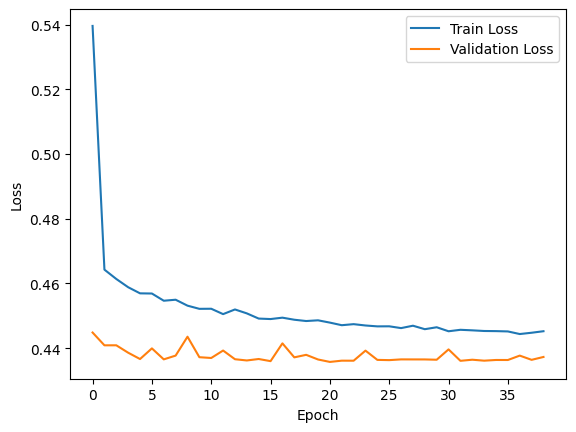

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 저장된 모델 가중치 불러오기
model.load_state_dict(torch.load("./TrafficAccidentPredictor.pth"))
model.eval()

# train_x 데이터를 텐서로 변환하여 모델에 입력
train_inp = torch.tensor(train_x.values, dtype=torch.float32)
train_inp_preds = train_inp.to(device)  # 모델의 디바이스로 옮기기

# 모델을 사용하여 예측 수행
with torch.no_grad():
    train_preds = model(train_inp_preds)

# targets을 모델의 디바이스로 옮기기
targets = torch.tensor(train_y.values, dtype=torch.float32)
targets = targets.to(device)

# RMSLE 계산 using RMSLELoss
criterion = RMSLELoss()
rmsle = criterion(train_preds, targets)

print(f"트레인 데이터에 대한 RMSLE: {rmsle.item():.4f}")


In [ ]:
# 테스트 데이터로 예측
with torch.no_grad():
    model.eval()
    test_inputs = torch.tensor(test_x.values, dtype=torch.float32)
    # test_inputs를 모델이 사용하는 디바이스로 옮기기
    test_inputs = test_inputs.to(device)
    predictions = model(test_inputs)

# 예측 결과 출력
print(predictions)

tensor([[3.8930],
        [3.5907],
        [4.8030],
        ...,
        [4.7229],
        [4.5466],
        [4.5366]], device='cuda:0')


In [ ]:
# CUDA(GPU)에서 CPU로 텐서 옮기기
predictions_array = predictions.cpu().numpy().flatten()
sample_submission["ECLO"] = predictions_array
sample_submission.to_csv('/content/drive/MyDrive/교통사고/result/submission_토치14.csv',index=False)